# Political geography notebook

## Multiscale analysis of Pennsylvania

### Function for making long multiscale scatter plots
This function uses seats data (stored in a data frame) to make a colorful multiscale scatter plot.

In [1]:
#function for making multiscale scatter plots
def multiscale_plot(shapefile, seats_data, election_name, election_columns):
    fig, ax = plt.subplots(figsize=(12,3))
    #get statewide share from our election data
    statewide_D_share = gdf[election_columns[0]].sum()/(
        gdf[election_columns[0]].sum()+gdf[election_columns[1]].sum()
    )
    plt.plot(
        [0,205],[statewide_D_share,statewide_D_share],
        linestyle='dashed',
        c='lightgreen'
    )
    #plot seats data
    for num_districts in seats_data.columns:
        k = float(num_districts)
        p = ax.scatter(
            [k]*len(seats_data[seats_data[num_districts]!=0]),
            [float(x)/k for x in seats_data[seats_data[num_districts]!=0].index],
            c=[x/seats_data[num_districts].sum() for x in seats_data[seats_data[num_districts]!=0][num_districts]],
            vmin=0,
            vmax=1,
            s=20,
            cmap='jet'
        )
    plt.xlabel("# districts")
    plt.ylabel("Democratic seat share")
    plt.plot([18,18],[0,1],linestyle='dashed',c='gray')
    plt.plot([50,50],[0,1],linestyle='dashed',c='gray')
    plt.plot([203,203],[0,1],linestyle='dashed',c='gray')
    plt.xlim(0,205)
    plt.ylim(0,1)
    plt.title(election_name)
    plt.colorbar(p)
    plt.show()

In [2]:
election_names = ["PRES16", "SEN16", "ATG12", "GOV14", "GOV10", "PRES12", "SEN10", "ATG16", "SEN12"]
election_columns = [
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["ATG12D", "ATG12R"],
    ["F2014GOVD", "F2014GOVR"],
    ["GOV10D", "GOV10R"],
    ["PRES12D", "PRES12R"],
    ["SEN10D", "SEN10R"],
    ["T16ATGD", "T16ATGR"],
    ["USS12D", "USS12R"]
] #DEM, REP

## Generate and analyze a toy ensemble 
Let's generate a small ensemble of plans just to see how it's done and how the output is converted into a plot.

### Setup and imports

In [3]:
from gerrychain import Graph, Partition, updaters, MarkovChain, constraints, Election
from functools import partial
from gerrychain.updaters import Tally
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from gerrychain.tree import recursive_tree_part
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
seats_data_for_all_elections = {e:pd.DataFrame() for e in election_names} 

In [4]:
#let's load a PA dual graph with election data
#each vertex is a precinct and edges connect adjacent precincts
graph = Graph.from_json("./pennsylvania/PA_VTD.json")
gdf = gpd.read_file("pennsylvania/PA_VTD_PLANS.shp")

### Let's collect some data 
Run the notebook from here with different num_districts to do a multiscale analysis

In [5]:
ensemble_size = 100 #how many plans to generate in your final ensemble
burn_in = 0 #throw away the first few steps of the chain
sample_interval = 1 #how often to sample from the chain -- the higher the better for a good ensemble
num_districts = 18 #how many districts in each plan

In [6]:
#set up a ReCom chain using gerrychain
#this is a pretty standard setup for a basic chain, see https://gerrychain.readthedocs.io/ for more
myupdaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
}
elections = [
        Election(
            election_names[i],
            {
                "Democratic": election_columns[i][0],
                "Republican": election_columns[i][1]
            },
        )
        for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
myupdaters.update(election_updaters)
total_population = sum([graph.nodes[n]["TOTPOP"] for n in graph.nodes()])
if num_districts == 18:
    initial_plan_to_start_chain = Partition(graph, "REMEDIAL", myupdaters)
else:
    print("Making an initial plan from scratch...")
    initial_plan_to_start_chain = Partition(
        graph,
        recursive_tree_part(
            graph,
            range(num_districts),
            total_population/num_districts,
            "TOTPOP",
            0.02),
        myupdaters
    )   
proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=total_population/num_districts,
    epsilon=0.02,
    node_repeats=10
)
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(
            initial_plan_to_start_chain,
            0.02
        ),
    ],
    accept=always_accept,
    initial_state=initial_plan_to_start_chain,
    total_steps=ensemble_size*sample_interval + burn_in
)

In [7]:
#let's run the chain!
seats_by_election = {e: np.zeros(205) for e in election_names} 
for i, step in enumerate(chain):
    print(i, end=" ")
    if i >= burn_in and i % sample_interval == 0:
        for e in election_names:
            seats_by_election[e][step[e].seats('Democratic')] += 1
for e in election_names:
    seats_data_for_all_elections[e][str(num_districts)] = seats_by_election[e]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [8]:
#let's look at some of the seats data we collected so far
seats_data_for_all_elections['PRES16'].head()

,18
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


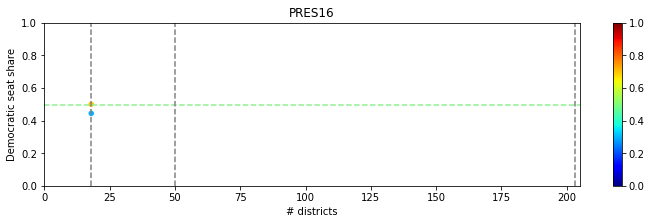

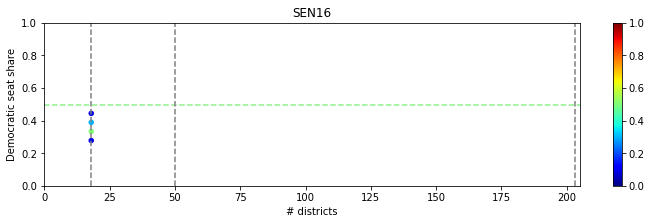

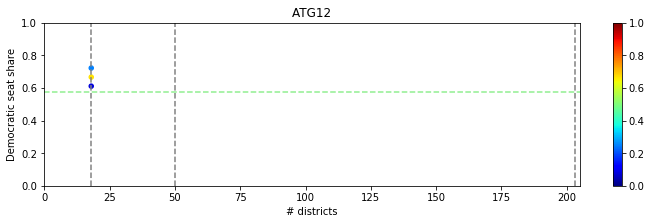

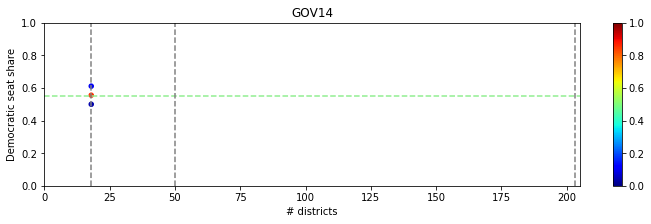

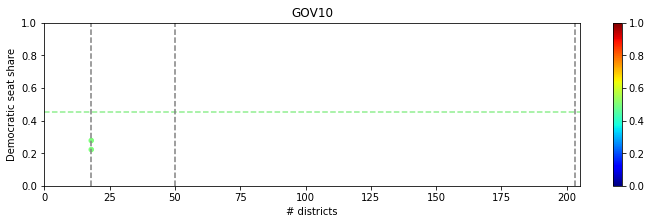

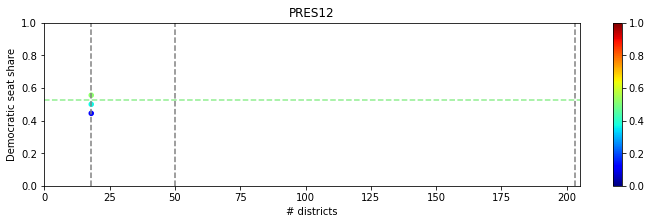

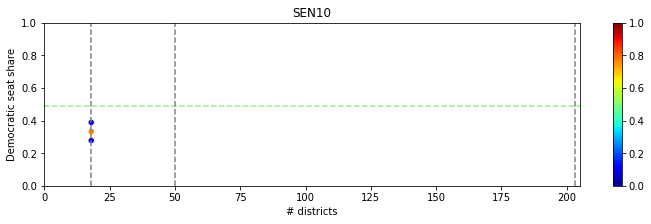

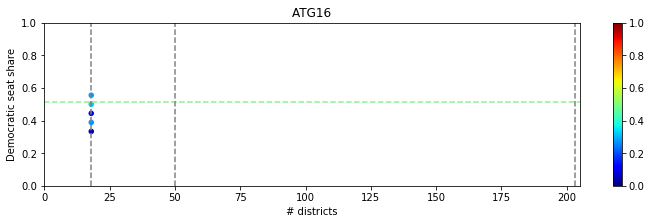

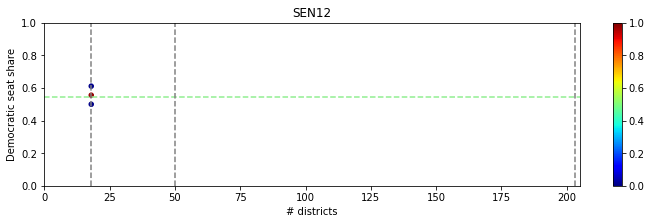

In [9]:
#and now we can plot our toy ensembles
for name, columns in zip(election_names, election_columns):
    multiscale_plot(
        gdf, seats_data_for_all_elections[name],
        name, columns
    ) 

You can now go back and run the chain with a different number of districts. The data will be added to the dataframe and then to the plots each time.

## Stored ensemble data from long runs on a high performance cluster 
Let's load some data from ensembles generated in the past on a high performance cluster and plot it.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [11]:
scales = list(range(3,53))+list(range(54,148))[::6]+[156,168,180,203]
scales = [str(x) for x in scales]

In [12]:
#load Pennsylvania election data
gdf = gpd.read_file("pennsylvania/PA_VTD_PLANS.shp")

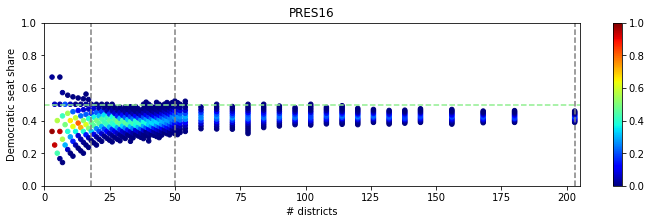

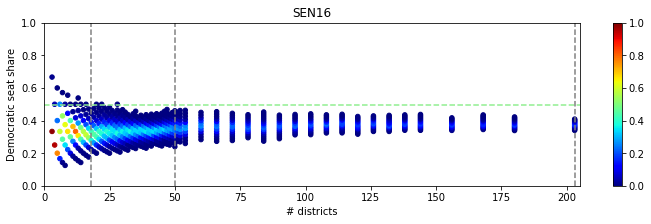

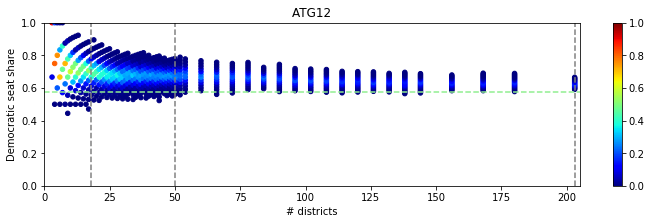

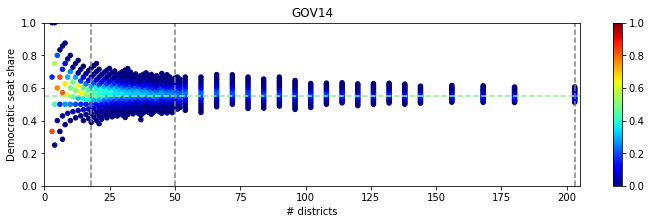

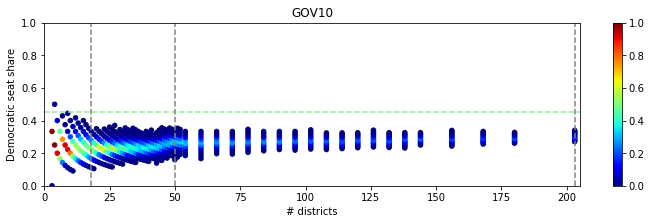

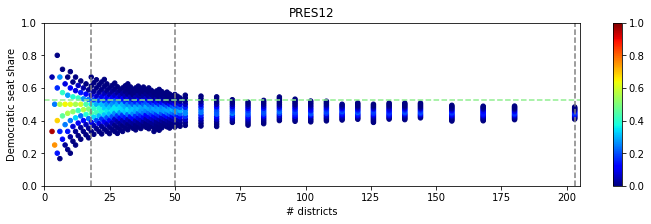

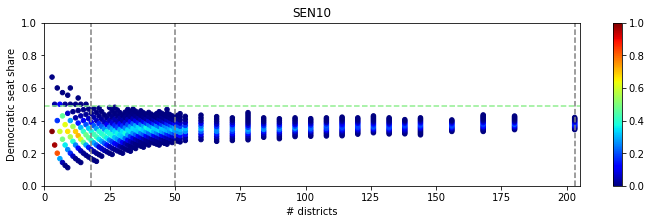

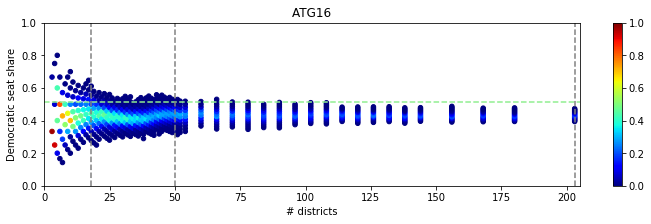

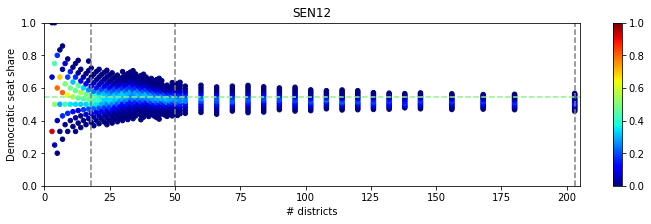

In [13]:
#make the scatter plots
for name, columns in zip(election_names, election_columns):
    multiscale_plot(
        gdf,
        pd.read_csv("seats_data/seats_{}.csv".format(name), index_col='seats'),
        name, columns
    )